## Introduction

This model is in line with the competition held by [Zindi Africa](https://zindi.africa/competitions/xente-fraud-detection-challenge) in detecting fraudulent transactions.

###### Environment setup 
Create an environment using an *Anaconda* with

```conda create -n fraud python=3```

Then activate the environment

```source activate fraud```

Install all the packages required for the setup:

 e.g ```conda install pandas```

In [2]:
!pip install seaborn
!pip install  matplotlib
!pip install xgboost
!pip install sklearn

     |████████████████████████████████| 142.8MB 411kB/s eta 0:00:01     |██████████████████▏             | 81.2MB 2.2MB/s eta 0:00:28     |███████████████████▊            | 88.2MB 2.8MB/s eta 0:00:20     |████████████████████▍           | 91.0MB 2.2MB/s eta 0:00:24     |███████████████████████▊        | 106.0MB 815kB/s eta 0:00:46     |██████████████████████████▌     | 118.3MB 3.9MB/s eta 0:00:07


In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(rc={'figure.figsize':(11,8)})

##### 1. Load the dataset:
Since we will combine both train and test data we will create a column name **train** which will distinguish them

In [3]:
train = pd.read_csv("training.csv")
train["train"] = 1
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,train
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,1
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,1
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,1
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,1
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,1


In [4]:
train.shape

(95662, 17)

Check the type of data we are dealing with

In [5]:
statistics = []

for column in train.columns:
    statistics.append((column, train[column].nunique(), train[column].isnull().sum() * 100 / train.shape[0], train[column].dtype))
    
statistics_df = pd.DataFrame(statistics, columns=["column", "unique_values", "percentage_of_missing_values", "data_type"])
statistics_df


,column,unique_values,percentage_of_missing_values,data_type
0,TransactionId,95662,0.0,object
1,BatchId,94809,0.0,object
2,AccountId,3633,0.0,object
3,SubscriptionId,3627,0.0,object
4,CustomerId,3742,0.0,object
5,CurrencyCode,1,0.0,object
6,CountryCode,1,0.0,int64
7,ProviderId,6,0.0,object
8,ProductId,23,0.0,object
9,ProductCategory,9,0.0,object


From the table above, there are **no missing values** in the train dataset, we also get the data types of each features and also the **cardinality** of the data

In [6]:
test = pd.read_csv("test.csv")
test["train"] = 0
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,train
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4,0
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2,0
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2,0
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4,0
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2,0


In [7]:
statistics_test = []

for column in test.columns:
    statistics_test.append((column, test[column].nunique(), test[column].isnull().sum() * 100 / test.shape[0], test[column].dtype))
    
statistics_test_df = pd.DataFrame(statistics_test, columns=["column", "unique_values", "percentage_of_missing_values", "data_type"])
statistics_test_df

,column,unique_values,percentage_of_missing_values,data_type
0,TransactionId,45019,0.0,object
1,BatchId,44684,0.0,object
2,AccountId,2471,0.0,object
3,SubscriptionId,2470,0.0,object
4,CustomerId,5018,0.0,object
5,CurrencyCode,1,0.0,object
6,CountryCode,1,0.0,int64
7,ProviderId,6,0.0,object
8,ProductId,26,0.0,object
9,ProductCategory,9,0.0,object


There also **no missing values** in the test dataset.

##### 2.Data Exploration

###### 2.1 Label column distribution

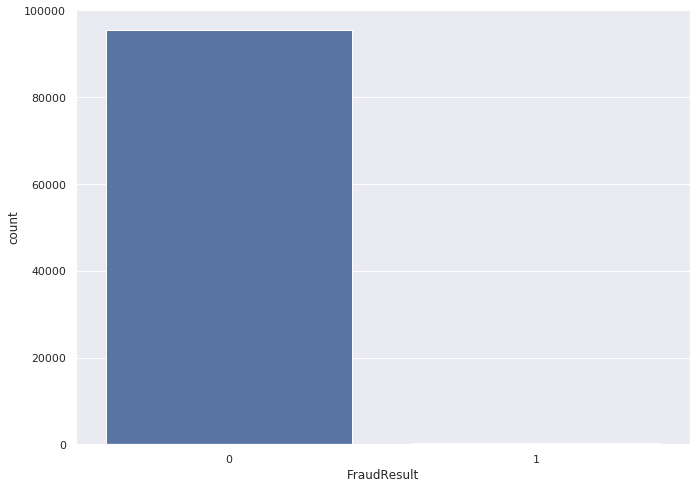

In [8]:
sns.countplot(train["FraudResult"])

In [9]:
print("Non Fraud case", round(train["FraudResult"].value_counts()[0]/ len(train) * 100, 3), "% of the dataset")
print("Fraud case", round(train["FraudResult"].value_counts()[1]/ len(train) * 100, 3), "% of the dataset")

Non Fraud case 99.798 % of the dataset
Fraud case 0.202 % of the dataset


This shows a case scenario of imbalanced dataset. One class(for this cass where FraudResult is 0) is highly represented. There various ways of handing imbalaced dataset:
    1. Overampling - 
    2. Undersampling - 
    3. Synthetic Sample - SMOTE
    4. Algorithm designed for imbalance dataset e.g XgBoost

###### 2.2 Provider Id distribution

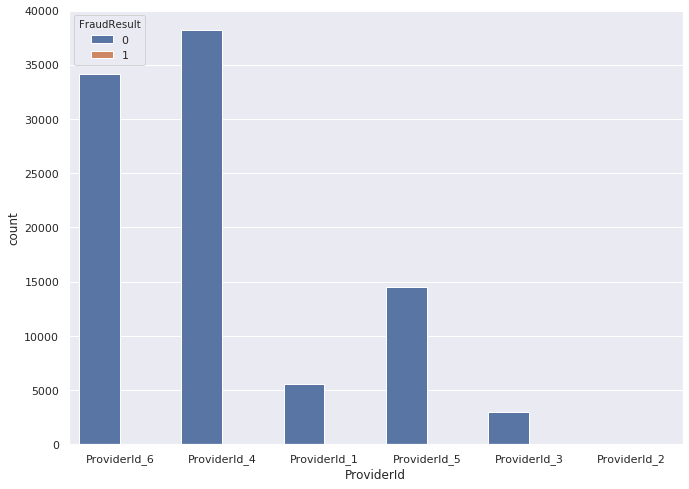

In [10]:
sns.countplot(train['ProviderId'], hue=train['FraudResult'])

**Note** Since this data is imbalanced it is hard to do visualization on all the train dataset, we will look at the dataset where there are cases of fraud. But we will also explore the whole dataset since we need to look at presence of each feature in relation to whether fraud or not

In [11]:
fraud_df = train[train["FraudResult"] == 1]

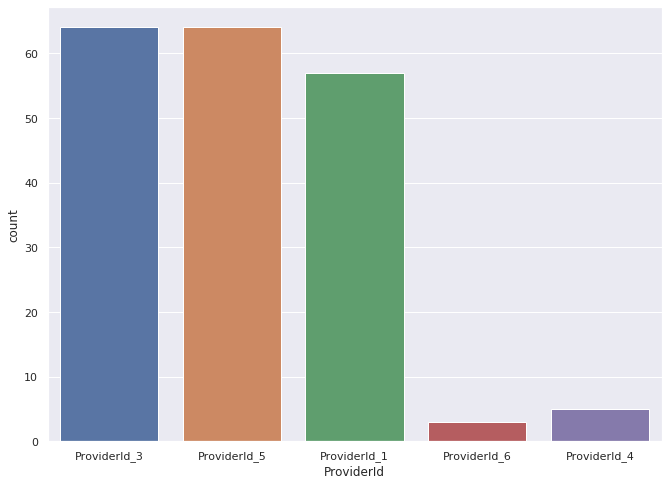

In [12]:
sns.countplot(fraud_df["ProviderId"])

Some provider are more prone to fraud than other.

###### 2.3 ProductId distribution

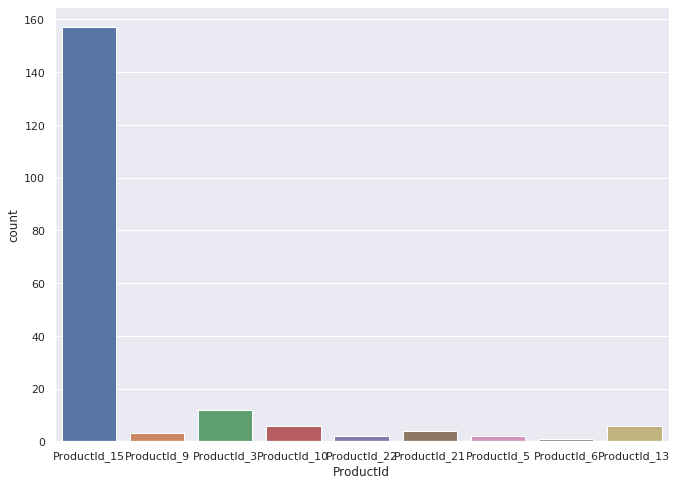

In [13]:
sns.countplot(fraud_df["ProductId"])

###### 2.4 ProductCategory

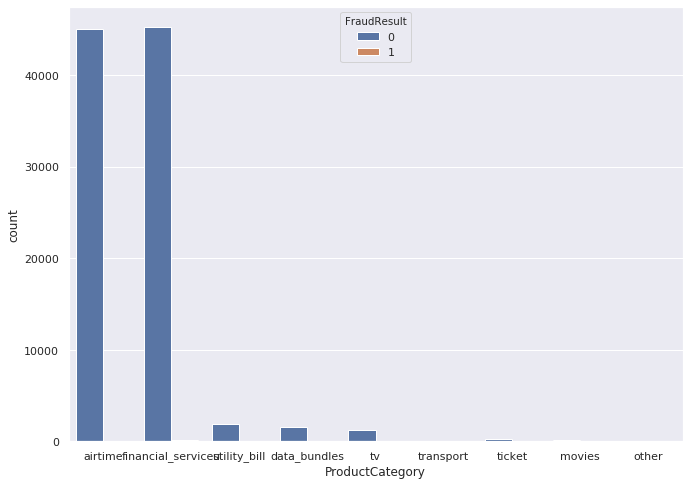

In [14]:
sns.countplot(train['ProductCategory'], hue=train['FraudResult'])

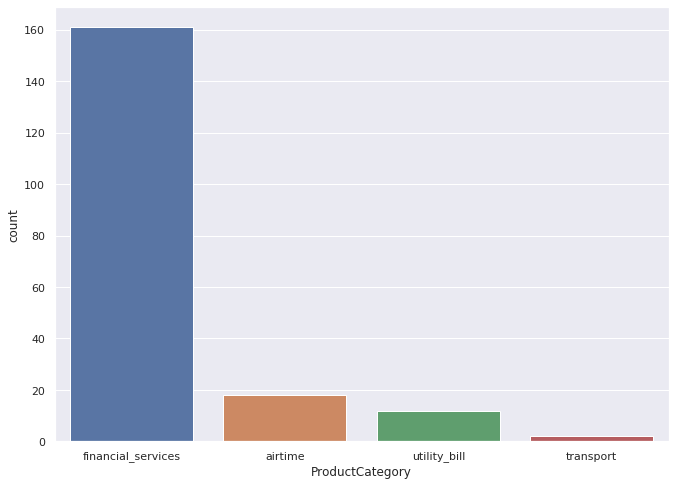

In [15]:
sns.countplot(fraud_df["ProductCategory"])

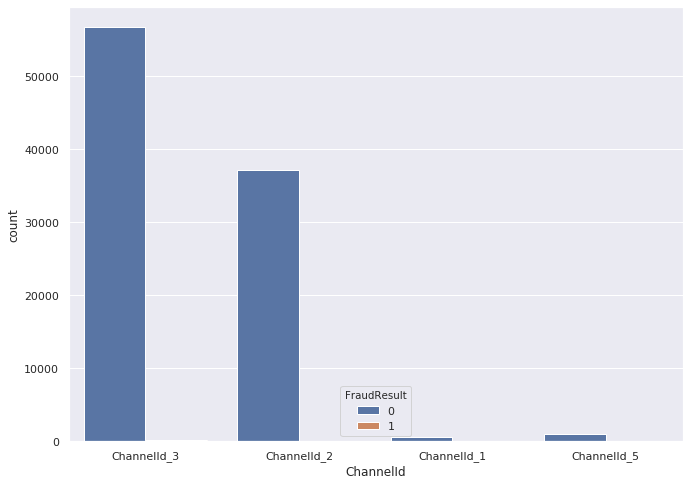

In [16]:
#ChannelId
sns.countplot(train['ChannelId'], hue=train['FraudResult'])

###### 2.5 ChannelId

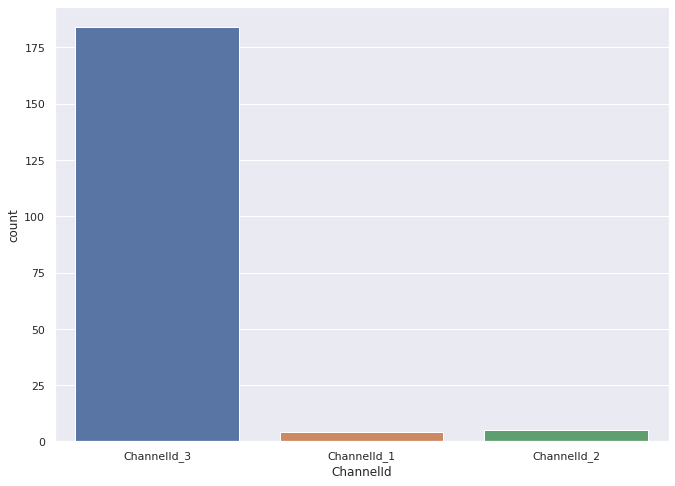

In [17]:
sns.countplot(fraud_df["ChannelId"])

###### 2.6 PricingStrategy

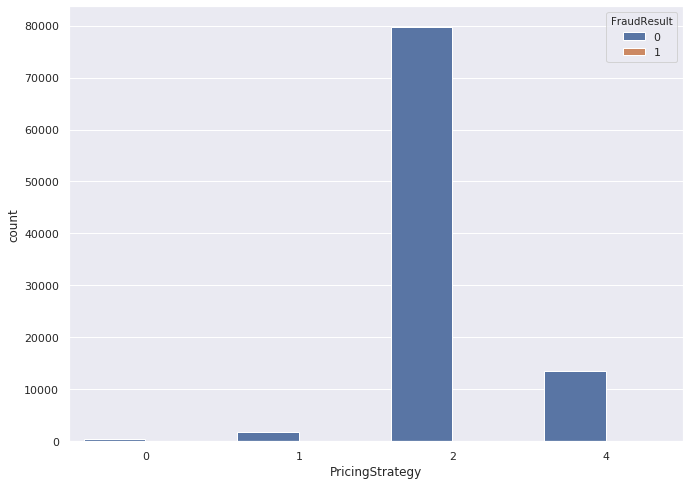

In [18]:
sns.countplot(train['PricingStrategy'], hue=train['FraudResult'])

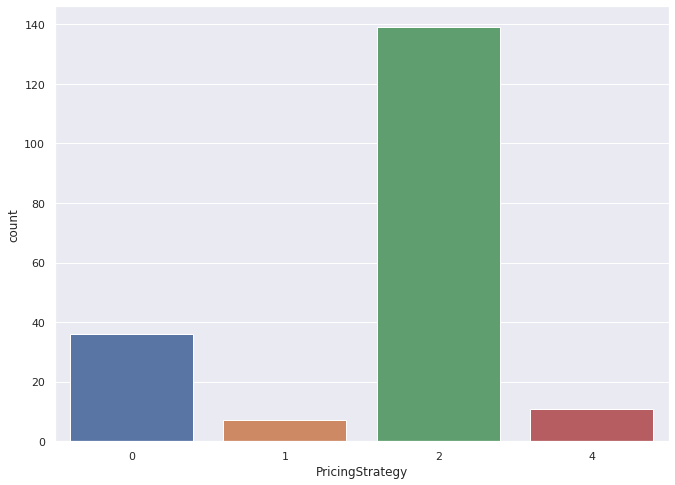

In [19]:
sns.countplot(fraud_df["PricingStrategy"])

From the above we see that all these features are important in determining if transaction was fraud or not.
We will preprocess these features to feed them to the model.

##### 3. Data preprocessing

In [20]:
# combine both train and test data
dataset = pd.concat([train, test], ignore_index=True)

From the **statistics_df** we can see some of the features are categorical. We will encode these features using pandas method **get_gummies**. Also features with high cardinality are not encoded.

In [21]:
dataset = pd.concat([dataset, pd.get_dummies(dataset["ChannelId"], prefix="Channel_Id_")], axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["PricingStrategy"], prefix="PricingStrategy_")], axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["ProductCategory"], prefix="ProductCategory_")], axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["ProductId"], prefix="ProductId_")], axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["ProviderId"], prefix="ProviderId_")], axis=1)


The time column  has a datatype of an object, we convert it to datetime so that we derive various features from it, e.g day of week 

In [22]:
# time
dataset["TransactionStartTime"] = dataset["TransactionStartTime"].apply(lambda x : pd.to_datetime(x))
dataset["day_of_week"] = dataset["TransactionStartTime"].dt.dayofweek
dataset["time"] = dataset["TransactionStartTime"].dt.time
dataset["second"] = dataset["time"].apply(lambda x: int(str(x).split(":")[0]) * 3600 + int(str(x).split(":")[1]) * 60 + int(str(x).split(":")[2]))

In [23]:
dataset.head()

,AccountId,Amount,BatchId,ChannelId,CountryCode,CurrencyCode,CustomerId,FraudResult,PricingStrategy,ProductCategory,...,ProductId__ProductId_9,ProviderId__ProviderId_1,ProviderId__ProviderId_2,ProviderId__ProviderId_3,ProviderId__ProviderId_4,ProviderId__ProviderId_5,ProviderId__ProviderId_6,day_of_week,time,second
0,AccountId_3957,1000.0,BatchId_36123,ChannelId_3,256,UGX,CustomerId_4406,0.0,2,airtime,...,0,0,0,0,0,0,1,3,02:18:49,8329
1,AccountId_4841,-20.0,BatchId_15642,ChannelId_2,256,UGX,CustomerId_4406,0.0,2,financial_services,...,0,0,0,0,1,0,0,3,02:19:08,8348
2,AccountId_4229,500.0,BatchId_53941,ChannelId_3,256,UGX,CustomerId_4683,0.0,2,airtime,...,0,0,0,0,0,0,1,3,02:44:21,9861
3,AccountId_648,20000.0,BatchId_102363,ChannelId_3,256,UGX,CustomerId_988,0.0,2,utility_bill,...,0,1,0,0,0,0,0,3,03:32:55,12775
4,AccountId_4841,-644.0,BatchId_38780,ChannelId_2,256,UGX,CustomerId_988,0.0,2,financial_services,...,0,0,0,0,1,0,0,3,03:34:21,12861


Always remember to convert the engineered features as well if they are categorical.

In [24]:
dataset = pd.concat([dataset, pd.get_dummies(dataset["day_of_week"], prefix="day_of_week_")], axis=1)

In [25]:
# id
dataset["AccountId"] = dataset["AccountId"].apply(lambda x: int(x.split("_")[1]))
dataset["CustomerId"] = dataset["CustomerId"].apply(lambda x: int(x.split("_")[1]))
dataset["SubscriptionId"] = dataset["SubscriptionId"].apply(lambda x: int(x.split("_")[1]))


Generate new features by using groupby. At this stage I also generate random noise to the dataset and create duplicate samples of the data. This will help deal with a bit of imblance data.

In [26]:
group = dataset[['CustomerId', 'ProductId', 'ProviderId', 'ChannelId', 'Amount', 'day_of_week']].groupby(by=['CustomerId', 'ProductId', 'ProviderId', 'ChannelId', 'Amount',])[['day_of_week']].mean().reset_index().rename(index=str, columns={'day_of_week': 'Cust_prod_mean_dayofweek'})
dataset = dataset.merge(group, on=['CustomerId', 'ProductId', 'ProviderId', 'ChannelId',], how='left')

In [27]:
#Drop unwanted columns.
dataset.drop(["CurrencyCode",  "CountryCode", "BatchId", "ChannelId",  "PricingStrategy", "ProductCategory", "ProductId", "ProviderId", "time", "TransactionStartTime",], axis=1, inplace=True)

In [28]:
train = dataset[dataset["train"] == 1]
test = dataset[dataset["train"] == 0]

In [29]:
train.drop(["train"], axis=1, inplace=True)
test.drop(["train", "FraudResult"], axis=1, inplace=True)

In [30]:
X = train.drop(["TransactionId", "FraudResult"], axis=1)
y = train["FraudResult"]

Split the dataset into train and test, also for such an imbalanced dataset, it a good practise to look at the percentage of fraud data in both datasets 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("Fraud case", (train["FraudResult"].value_counts()[1]/ len(train) * 100), "% of the dataset")
print ("Train size", y_train.shape[0], "Fraud in train size", y_train[y_train == 1].shape[0] / y_train.shape[0] * 100)
print ("Test size", y_test.shape[0], "Fraud in tesst size", y_test[y_test == 1].shape[0] / y_test.shape[0] * 100)

Fraud case 0.30303583490023545 % of the dataset
Train size 587230 Fraud in train size 0.30788617747730873
Test size 289234 Fraud in tesst size 0.29318821438696696


#####  4. Model selection and training

###### 4.1 Random Forest Classifier

**Note** for the parameter tuning and selection, I used **Grid Serach CV**, I'm also using **Random state** to make the code reproducable when run mutliple times the data will be split the same.

In [32]:
rfc = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=8)

In [33]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [34]:
rfc_pred = rfc.predict(X_test)

In [35]:
print("rfc ", classification_report(y_test, rfc_pred) )

rfc                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    288386
         1.0       0.98      0.95      0.96       848

    accuracy                           1.00    289234
   macro avg       0.99      0.97      0.98    289234
weighted avg       1.00      1.00      1.00    289234



###### 4.6 XGBoost

In [36]:
# classifier
xg_cl = xgb.XGBClassifier(objective="binary:logistic",
                          n_estimators=100, colsample_bytree=0.7, subsample=0.7, max_depth=5, learning_rate=0.1, seed=42)

In [37]:
xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.7, verbosity=1)

In [38]:
preds = xg_cl.predict(X_test)

In [39]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    288386
         1.0       1.00      0.98      0.99       848

    accuracy                           1.00    289234
   macro avg       1.00      0.99      0.99    289234
weighted avg       1.00      1.00      1.00    289234



###### Predict on the test data

In [40]:
test.head()

,AccountId,Amount_x,CustomerId,SubscriptionId,TransactionId,Value,Channel_Id__ChannelId_1,Channel_Id__ChannelId_2,Channel_Id__ChannelId_3,Channel_Id__ChannelId_4,...,second,day_of_week__0,day_of_week__1,day_of_week__2,day_of_week__3,day_of_week__4,day_of_week__5,day_of_week__6,Amount_y,Cust_prod_mean_dayofweek
876464,2441,1000.0,2857,4426,TransactionId_50600,1000,0,0,1,0,...,36100,0,0,1,0,0,0,0,500.0,4.000000
876465,2441,1000.0,2857,4426,TransactionId_50600,1000,0,0,1,0,...,36100,0,0,1,0,0,0,0,1000.0,2.315789
876466,2441,1000.0,2857,4426,TransactionId_50600,1000,0,0,1,0,...,36100,0,0,1,0,0,0,0,2000.0,3.000000
876467,2441,1000.0,2857,4426,TransactionId_50600,1000,0,0,1,0,...,36100,0,0,1,0,0,0,0,3000.0,3.666667
876468,2441,1000.0,2857,4426,TransactionId_50600,1000,0,0,1,0,...,36100,0,0,1,0,0,0,0,3300.0,2.000000


In [41]:
test_pred = pd.DataFrame()
test_pred['TransactionId'] = test["TransactionId"]
test.drop(["TransactionId"], axis=1, inplace=True)
predict_test =rfc.predict(test)
test_pred['FraudResult'] = predict_test
test_pred.to_csv('submission.csv', index=False)

#### Conclusion

I chose to use Random Forest Classifier over Xgboost since for this case I got a higher f1 score on the Leaderboard. I stated earlier that we are dealing with imblanced dataset, I tried various method e.g Random Oversampling, Undersampling and SMOTE all these methods did not work for this case. The only way that I improved it was adding noise to the data by creating 
duplicate samples of the dataset. 

This model was trained on a kaggle kernels with access to GPUs which made it faster and easier than my local machine.


**Thoughts** - This may not have been the best model score, but for cases of fraud we need alot more dataset where the model can learn from.

I had removed the code for Grid Search Cv since it's taking a longer time:- You can access it here:- You can change the estimator to xgboost as well.


```
rfc_param_grid = {
                    'n_estimators': [100, 200, 250, 300, 400],
                     'max_depth': [5, 7, 8, 10],
                     }
                     
rfc_cv =  RandomForestClassifier(random_state=1)
    
     
grid_mse = GridSearchCV(param_grid=rfc_param_grid, estimator=rfc_cv,
scoring="f1", cv=4 )
grid_mse.fit(X, y)
grid_mse.best_params_
grid_mse.best_score_
    
```

